# Example: mesh a delineated watershed

Here we mesh the [Coweeta Hydrologic Laboratory](https://www.srs.fs.usda.gov/coweeta/) as an example of how to pull data in from default locations and generate a fully functional ATS mesh.

This might be the worst example to use to learn how to use Watershed Workflows.  But it is useful to demonstrate the breadth of problems this project was intended to solve.

This includes a range of datasets:

* NHD Plus for river network
* NRCS soils data for soil types
* NLCD for land cover/transpiration/rooting depths
* NED for elevation

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm as pcm
import shapely
import logging
import pandas
import datetime
pandas.options.display.max_columns = None

import watershed_workflow
import watershed_workflow.source_list
import watershed_workflow.ui
import watershed_workflow.colors
import watershed_workflow.condition
import watershed_workflow.mesh
import watershed_workflow.split_hucs
import watershed_workflow.land_cover_properties

import watershed_workflow.sources.standard_names as names

watershed_workflow.ui.setup_logging(1, None)
figsize = (6,6)
figsize_3d = (8,6)


In [3]:
# Note that, by default, we tend to work in the DayMet CRS because this allows us to avoid
# reprojecting meteorological forcing datasets.
crs = watershed_workflow.crs.daymet_crs

## Sources and setup

Next we set up the source watershed and coordinate system and all data sources for our mesh.  We will use the CRS that is included in the shapefile.

In [4]:
# specify the input shapefile and a hint as to what HUC it is in.
coweeta_shapefile = 'Coweeta/input_data/coweeta_basin.shp'
hint = '0601'  # hint: HUC 4 containing this shape.  
               # This is necessary to avoid downloading all HUCs to search for this shape
simplify = 30 # length scale to target average edge

# start and end of simulation -- one year of simulation that is in both the MODIS and DayMet dataset ranges
start = datetime.date(2010,8,1)
end = datetime.date(2011,8,1)

logging.info("")
logging.info("Meshing shape: {}".format(coweeta_shapefile))
logging.info("="*30)

# get the shape and crs of the shape
coweeta = watershed_workflow.getShapes(coweeta_shapefile)
coweeta.rename(columns={'AREA' : names.AREA, 'LABEL' : names.NAME}, inplace=True)
coweeta[names.ID] = coweeta.index.values
coweeta.set_index(names.ID, inplace=True, drop=True)

2025-06-18 08:47:39,392 - root - INFO: 
2025-06-18 08:47:39,393 - root - INFO: Meshing shape: Coweeta/input_data/coweeta_basin.shp
2025-06-18 08:47:39,394 - root - INFO: ==============================


A wide range of data sources are available; here we use the defaults except for using NHD Plus for watershed boundaries and hydrography (the default is NHD, which is lower resolution and therefore smaller download sizes).

In [5]:
# Note that, by default, we tend to work in the DayMet CRS because this allows us to avoid
# reprojecting meteorological forcing datasets.
crs = coweeta.crs


In [6]:
# set up a dictionary of source objects
sources = watershed_workflow.source_list.get_default_sources()
# sources['depth to bedrock'] = watershed_workflow.source_list.FileManagerSoilGrids2017() # not available yet

#
# This demo uses a few datasets that have been clipped out of larger, national
# datasets and are distributed with the code.  This is simply to save download
# time for this simple problem and to lower the barrier for trying out
# Watershed Workflow.  A more typical workflow would delete these lines (as 
# these files would not exist for other watersheds).
#
# The default versions of these download large raster and shapefile files that
# are defined over a very large region (globally or the entire US).
#
# Note we also prepopulate some data for MODIS data as well.
#
sources['land cover'] = watershed_workflow.source_list.ManagerRaster('Coweeta/input_data/land_cover/land_cover.tif')
sources['hydrography'] = watershed_workflow.source_list.hydrography_sources['NHDv2.1']
# sources['geologic structure'] = watershed_workflow.source_list.ManagerGLHYMPS('Coweeta/input_data/GLHYMPS/GLHYMPS.shp') # not available yet
sources['depth to bedrock'] = watershed_workflow.source_list.ManagerRaster('Coweeta/input_data/DTB/DTB.tif')
watershed_workflow.source_list.log_sources(sources)

2025-06-18 08:47:39,463 - root - INFO: Using sources:
2025-06-18 08:47:39,463 - root - INFO: --------------
2025-06-18 08:47:39,463 - root - INFO: HUC: WaterData
2025-06-18 08:47:39,464 - root - INFO: hydrography: WaterData
2025-06-18 08:47:39,464 - root - INFO: DEM: 3DEP
2025-06-18 08:47:39,464 - root - INFO: land cover: raster
2025-06-18 08:47:39,465 - root - INFO: depth to bedrock: raster


In [7]:
# immediately put in request for land cover data -- downloading from Appeears
# can take some time as they must synthesize the data 

## Generate the surface mesh

First we'll generate the flattened, 2D triangulation, which builds on hydrography data.  Then we download a digital elevation map from the National Elevation Dataset, and extrude that 2D triangulation to a 3D surface mesh based on interpolation between pixels of the DEM.

2025-06-18 08:47:39,506 - root - INFO: Removing holes on 1 polygons
2025-06-18 08:47:39,507 - root - INFO:   -- removed interior
2025-06-18 08:47:39,507 - root - INFO:   -- union
2025-06-18 08:47:39,508 - root - INFO: Parsing 1 components for holes
2025-06-18 08:47:39,508 - root - INFO:   -- complete


<Axes: >

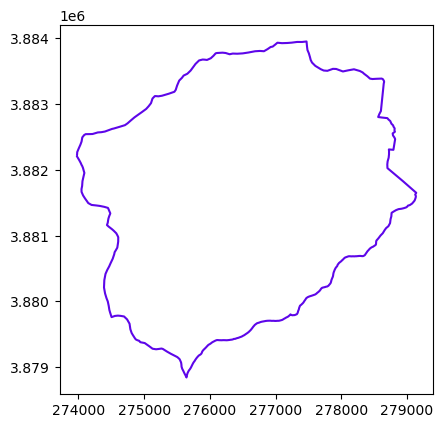

In [8]:
watershed = watershed_workflow.split_hucs.SplitHUCs(coweeta)
watershed.plot()

In [9]:
include_rivers = True

if include_rivers:  
    # download/collect the river network within that shape's bounds
    reaches = watershed_workflow.getShapesByGeometry(sources['hydrography'], watershed.exterior, crs, crs)
    rivers = watershed_workflow.river_tree.createRivers(reaches, method='hydroseq')

watershed_orig, rivers_orig = watershed, rivers



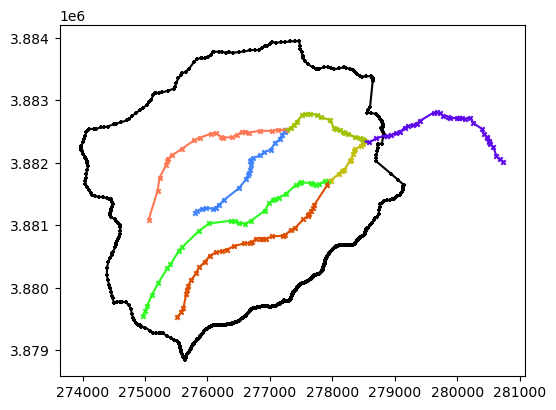

In [10]:
def plot(ws, rivs, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    ws.plot(color='k', marker='+', markersize=10, ax=ax)
    for river in rivs:
        river.plot(marker='x', markersize=10, ax=ax)

plot(watershed, rivers)

In [11]:
# keeping the originals for plotting comparisons
def createCopy(watershed, rivers):
    """To compare before/after, we often want to create copies.  Note in real workflows most things are done in-place without copies."""
    return watershed.deepcopy(), [r.deepcopy() for r in rivers]
    
watershed, rivers = createCopy(watershed_orig, rivers_orig)

# simplifying 
watershed_workflow.simplify(watershed, rivers, 75, 75, 100, 500)

2025-06-18 08:47:46,384 - root - INFO: 
2025-06-18 08:47:46,384 - root - INFO: Simplifying
2025-06-18 08:47:46,384 - root - INFO: ------------------------------
2025-06-18 08:47:46,385 - root - INFO: Presimplify to remove colinear, coincident points.
2025-06-18 08:47:46,386 - root - INFO: Pruning leaf reaches < 75
2025-06-18 08:47:46,386 - root - INFO: Merging internal reaches < 75
2025-06-18 08:47:46,387 - root - INFO:   reach: min seg length: 	   12.9054412052 	min geom length: 	  896.3129477630
2025-06-18 08:47:46,388 - root - INFO:   reach: med seg length: 	   79.0153132834 	med geom length: 	 2780.6074649589
2025-06-18 08:47:46,388 - root - INFO:   reach: max seg length: 	  488.0172051672 	max geom length: 	 4026.7639594366
2025-06-18 08:47:46,388 - root - INFO: 
2025-06-18 08:47:46,389 - root - INFO:   HUC  : min seg length: 	    6.0465606669 	min geom length: 	17521.7680419622
2025-06-18 08:47:46,389 - root - INFO:   HUC  : med seg length: 	   20.1713567722 	med geom length: 	17

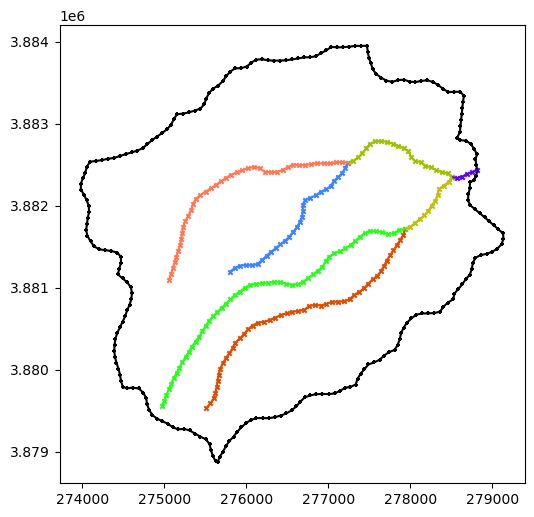

In [12]:
plot(watershed, rivers)

In [13]:
rivers[0].df.index

Index(['19736291', '19736305', '19736307', '19736315', '19736317', '19736355',
       '19736357'],
      dtype='string', name='ID')

In [14]:
rivers[0].df.index.name

'ID'

In [15]:
# this should generate a zoomable map, showing different reaches and watersheds, 
# with discrete points.  Problem areas are clickable to get IDs for manual
# modifications.
m = watershed.explore(marker=False)
for river in rivers_orig:
    m = river.explore(m=m, column=None, color='black', name=river['name']+' raw', marker=False)
for river in rivers:
    m = river.explore(m=m)
    
# m = watershed_workflow.makeMap(m)
m

2025-06-18 08:47:47,366 - root - INFO: 
2025-06-18 08:47:47,367 - root - INFO: Triangulation
2025-06-18 08:47:47,367 - root - INFO: ------------------------------
2025-06-18 08:47:47,380 - root - INFO: Triangulating...
2025-06-18 08:47:47,381 - root - INFO:    235 points and 235 facets
2025-06-18 08:47:47,381 - root - INFO:  checking graph consistency
2025-06-18 08:47:47,382 - root - INFO:  tolerance is set to 1.0
2025-06-18 08:47:47,383 - root - INFO:  building graph data structures
2025-06-18 08:47:47,384 - root - INFO:  triangle.build...
2025-06-18 08:48:58,070 - root - INFO:   ...built: 6605 mesh points and 12973 triangles
2025-06-18 08:48:58,070 - root - INFO: Plotting triangulation diagnostics
2025-06-18 08:48:58,411 - root - INFO:   min area = 260.78289794921875
2025-06-18 08:48:58,412 - root - INFO:   max area = 4999.3101806640625


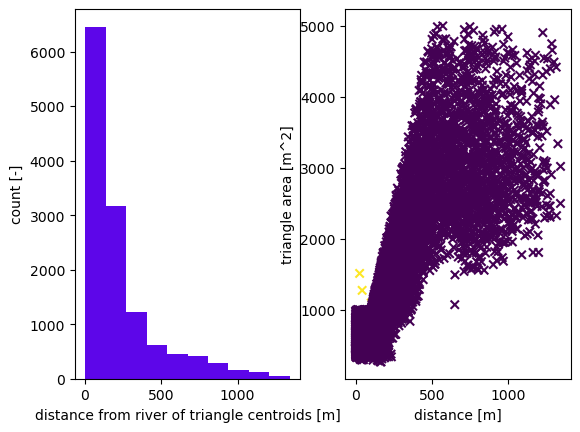

In [16]:
# form a triangulation on the shape + river network

# triangulation refinement:
# Refine triangles if their area (in m^2) is greater than A(d), where d is the 
# distance from the triangle centroid to the nearest stream.
# A(d) is a piecewise linear function -- A = A0 if d <= d0, A = A1 if d >= d1, and
# linearly interpolates between the two endpoints.
d0 = 100; d1 = 500
A0 = 1000; A1 = 5000


# Refine triangles if they get too acute
min_angle = 32 # degrees

# make 2D mesh
m2, areas, dists = watershed_workflow.triangulate(watershed, rivers, 
                                               refine_distance=[d0,A0,d1,A1],
                                               refine_min_angle=min_angle,
                                               diagnostics=True)


In [17]:
# get a raster for the elevation map, based on NED
dem = sources['DEM'].getDataset(watershed.exterior.buffer(100), watershed.crs)

# elevate the triangle nodes to the dem
watershed_workflow.elevate(m2, dem)

Plotting the resulting mesh can be done in a variety of ways, including both 3D plots and mapview.  We show both here, but hereafter use mapview plots as they are a bit clearer (if not so flashy)...

2025-06-18 10:06:03,617 - matplotlib.axes._base - WARNING: Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


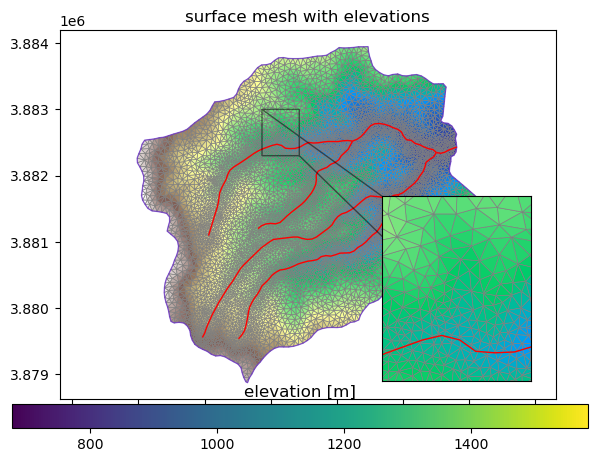

In [70]:
# plot the resulting surface mesh
fig, ax = plt.subplots()
ax2 = ax.inset_axes([0.65,0.05,0.3,0.5])
cbax = fig.add_axes([0.05,0.05,0.9,0.05])

# Get elevation data range
elev_min = m2.coords[:,2].min()
elev_max = m2.coords[:,2].max()

# Create normalized colormap
norm = plt.Normalize(vmin=elev_min, vmax=elev_max)

mp = m2.plot(facecolors='elevation', ax=ax, linewidth=0.5, cmap='terrain', norm=norm)
watershed.plot(ax=ax, alpha=0.5, linewidth=1)
rivers[0].plot(ax=ax, color='red', linewidth=1)
cbar = fig.colorbar(mp, orientation="horizontal", cax=cbax)
ax.set_title('surface mesh with elevations')
ax.set_aspect('equal', 'datalim')

mp2 = m2.plot(facecolors='elevation', ax=ax2, cmap='terrain', norm=norm)
rivers[0].plot(ax=ax2, color='red', linewidth=1)
ax2.set_aspect('equal', 'datalim')

xlim = (275900., 276400.)
ylim = (3882300., 3883000.)

ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
ax2.set_xticks([])
ax2.set_yticks([])

ax.indicate_inset_zoom(ax2, edgecolor='k')

cbar.ax.set_title('elevation [m]')

plt.show()

In [23]:
import copy
m2_before_conditioning = copy.deepcopy(m2)

In [24]:
# hydrologically condition the mesh, removing pits
watershed_workflow.condition.fillPitsDual(m2)


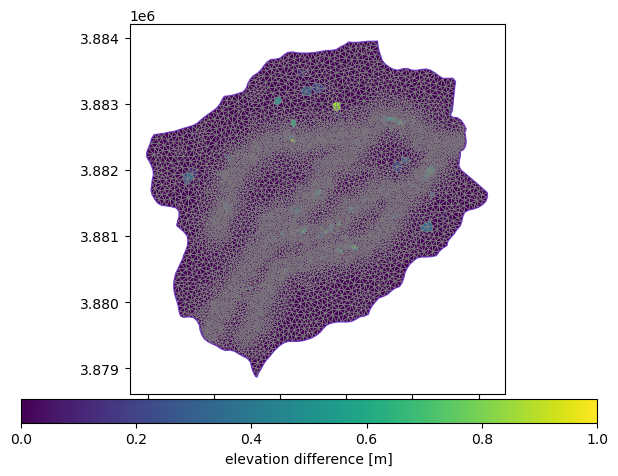

In [29]:
m2_diff = copy.deepcopy(m2)
m2_diff.coords[:,2] = m2.coords[:,2] - m2_before_conditioning.coords[:,2]

# plot the resulting surface mesh
fig, ax = plt.subplots()

# plot the mesh with elevation differences
mp = m2_diff.plot(facecolors='elevation', ax=ax, cmap='viridis')
watershed.plot(ax=ax, alpha=0.5, linewidth=1)

# add colorbar with explicit axes
cbax = fig.add_axes([0.05,0.05,0.9,0.05])
cbar = fig.colorbar(mp, orientation="horizontal", cax=cbax)
cbar.set_label('elevation difference [m]')

plt.show()

## Surface properties

Meshes interact with data to provide forcing, parameters, and more in the actual simulation.  Specifically, we need vegetation type on the surface to provide information about transpiration and subsurface structure to provide information about water retention curves, etc.

We'll start by downloading and collecting land cover from the NLCD dataset, and generate sets for each land cover type that cover the surface.  Likely these will be some combination of grass, deciduous forest, coniferous forest, and mixed.

In [30]:
# download the NLCD raster
lc_raster = sources['land cover'].getDataset(watershed.exterior.buffer(100), watershed.crs)
# resample the raster to the triangles
lc = watershed_workflow.getDatasetOnMesh(m2, lc_raster, method= 'nearest')

# what land cover types did we get?
logging.info('Found land cover dtypes: {}'.format(lc.dtype))
logging.info('Found land cover types: {}'.format(set(list(lc[:].ravel()))))

/opt/anaconda3/envs/ww_geopandas_xarray/lib/python3.13/site-packages/xarray/core/duck_array_ops.py:253: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
2025-06-18 08:55:12,253 - root - INFO: Found land cover dtypes: uint8
2025-06-18 08:55:12,254 - root - INFO: Found land cover types: {np.uint8(41), np.uint8(42), np.uint8(43), np.uint8(81), np.uint8(52), np.uint8(21), np.uint8(22), np.uint8(23)}


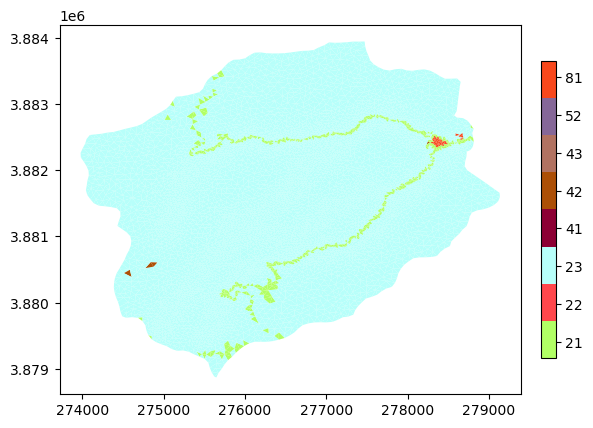

In [68]:
# plot the NLCD data
fig, ax = plt.subplots()

# -- get the NLCD colormap which uses official NLCD colors and labels
nlcd_indices, nlcd_cmap, nlcd_norm, nlcd_ticks, nlcd_labels = \
                watershed_workflow.colors.generate_indexed_colormap(lc)
# plot the mesh with NLCD colors
mp = m2.plot(facecolors=lc, cmap=nlcd_cmap, norm=nlcd_norm, 
             edgecolor='none', linewidth=0.5, ax=ax)

# add colorbar
watershed_workflow.colors.colorbar_index(ncolors=len(nlcd_indices), cmap=nlcd_cmap, 
                                         labels=nlcd_labels, ax=ax) 

plt.show()

In [158]:
# download MODIS data for LAI, block until it is finished!
#
# NOTE: if you get an error here about MODIS AppEEARs username and password, realize that 
# you must register for a login in the AppEEARs database.  See:
print(sources['lai'].__doc__)

modis = sources['lai'].get_data(coweeta.exterior(), crs, start, end)
if not isinstance(modis, watershed_workflow.datasets.State):
    modis = sources['lai'].wait(modis)


# resample the raster to the triangles
modis_lc = watershed_workflow.values_from_raster(m2.centroids, crs, modis['LULC'].data[0,:,:], 
                                                 modis['LULC'].profile)

# what land cover types did we get?
logging.info('Found land cover dtypes: {}'.format(modis_lc.dtype))
logging.info('Found land cover types: {}'.format(set(modis_lc)))


KeyError: 'lai'

In [159]:
# plot the modis lulc data

# -- get the MODIS colormap which uses official MODIS colors and labels
modis_indices, modis_cmap, modis_norm, modis_ticks, modis_labels = \
                watershed_workflow.colors.generate_modis_colormap(modis_lc)

# plot the image
fig = plt.figure(figsize=figsize)
ax = watershed_workflow.plot.get_ax(crs, fig)

polys = watershed_workflow.plot.mesh(m2, crs, ax=ax, color=lc, cmap=modis_cmap, 
                                     norm=modis_norm, edgecolor='none', 
                                     facecolor='color', linewidth=0.5)
watershed_workflow.colors.colorbar_index(ncolors=len(modis_indices), cmap=modis_cmap, 
                                         labels=modis_labels, ax=ax) 
ax.set_title("MODIS land cover index")

AttributeError: module 'watershed_workflow.colors' has no attribute 'generate_modis_colormap'

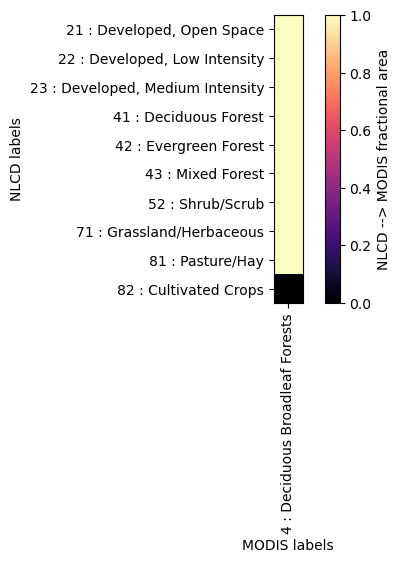

In [19]:
# determine a crosswalk between NLCD and MODIS -- for each NLCD index, 
# what MODIS index correlates best.  Note that while it is obvious here that
# all NLCD will map to MODIS 4, we do it anyway because this will not be true in general
crosswalk = watershed_workflow.land_cover_properties.computeMaximalCrosswalkCorrelation(
    modis['LULC'].profile, modis['LULC'].data[0,:,:], lc_profile, lc_raster)


In [20]:
# compute annually averaged LAI for each modis label
lai_time_series = watershed_workflow.land_cover_properties.computeTimeSeries(
    modis['LAI'], modis['LULC'])
print(lai_time_series)

        time [datetime]  Deciduous Broadleaf Forests LAI [-]
0   2010-08-01 00:00:00                                3.805
1   2010-08-05 00:00:00                                5.935
2   2010-08-09 00:00:00                                5.155
3   2010-08-13 00:00:00                                5.845
4   2010-08-17 00:00:00                                5.225
..                  ...                                  ...
88  2011-07-16 00:00:00                                5.690
89  2011-07-20 00:00:00                                4.100
90  2011-07-24 00:00:00                                5.765
91  2011-07-28 00:00:00                                4.390
92  2011-08-01 00:00:00                                5.525

[93 rows x 2 columns]


In [21]:
# write LAI to disk
filename = os.path.join('Coweeta', 'output_data', 'coweeta_lai.h5')
watershed_workflow.io.write_timeseries_to_hdf5(filename, lai_time_series)
                                               


2024-07-18 10:49:59,928 - root - INFO: Writing HDF5 file: Coweeta/output_data/coweeta_lai.h5


## Subsurface properties

Get soil structure from SSURGO.  By soil structure, here we calculate, for each formation identified in SSURGO, a soil depth, porosity, permeability, and percent sand/silt/clay (which are then handed off to Rosetta to get a van Genuchten model). 

Below this soil we also identify a geologic layer provided by GLHYMPS.  This provides information about the deeper subsurface.

### SSURGO Soil Properties

In [22]:
# download the NRCS soils data as shapes and project it onto the mesh

# -- download the shapes
soil_profile, soil_survey, soil_survey_props = \
        watershed_workflow.get_shapes(sources['soil structure'], [coweeta.exterior(),],
                                      crs, crs, properties=True)


# -- determine the NRCS mukey for each soil unit; this uniquely identifies soil 
#    properties
soil_ids = np.array(soil_survey_props['mukey'][:], np.int32)
    
# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
soil_color_profile, soil_color_raster = watershed_workflow.color_raster_from_shapes(soil_survey, crs, soil_ids,
                                                                                    coweeta.exterior().bounds, 10, crs, -1)

# -- resample the raster to the triangles
soil_color = watershed_workflow.values_from_raster(m2.centroids, crs, 
                                         soil_color_raster, soil_color_profile)



2024-07-18 10:49:59,941 - root - INFO: 
2024-07-18 10:49:59,941 - root - INFO: Loading shapes
2024-07-18 10:49:59,941 - root - INFO: ------------------------------
2024-07-18 10:49:59,950 - root - INFO: Attempting to download source for target '/home/ecoon/code/watershed_workflow/data/soil_structure/SSURGO/SSURGO_-83.4790_35.0269_-83.4208_35.0743.shp'
2024-07-18 10:50:00,028 - root - INFO:   Found 490 shapes.
2024-07-18 10:50:00,029 - root - INFO:   and crs: EPSG:4326
2024-07-18 10:50:00,029 - root - INFO:   Downloaded 490 total shapes
2024-07-18 10:50:00,031 - root - INFO:   Downloaded 43 unique mukeys
2024-07-18 10:50:00,122 - root - INFO: found 43 unique MUKEYs.
2024-07-18 10:50:00,921 - root - INFO: Running Rosetta for van Genutchen parameters
2024-07-18 10:50:00,968 - root - INFO:   ... done
2024-07-18 10:50:00,969 - root - INFO:   requested 43 values
2024-07-18 10:50:00,970 - root - INFO:   got 43 responses
2024-07-18 10:50:00,975 - root - INFO: ... found 43 shapes
2024-07-18 10:

In [23]:
soil_survey_props



,mukey,residual saturation [-],Rosetta porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],Rosetta permeability [m^2],thickness [cm],permeability [m^2],porosity [-],bulk density [g/cm^3],total sand pct [%],total silt pct [%],total clay pct [%],source
0,545800,0.177165,0.431041,0.000139,1.470755,8.079687e-13,203.0,3.429028e-15,0.307246,1.297356,66.356250,19.518750,14.125000,NRCS
1,545801,0.177493,0.432741,0.000139,1.469513,8.184952e-13,203.0,3.247236e-15,0.303714,1.292308,66.400000,19.300000,14.300000,NRCS
2,545803,0.172412,0.400889,0.000150,1.491087,6.477202e-13,203.0,2.800000e-12,0.379163,1.400000,66.799507,21.700493,11.500000,NRCS
3,545805,0.177122,0.388687,0.000083,1.468789,3.412748e-13,203.0,2.800000e-12,0.384877,1.400000,46.721675,41.778325,11.500000,NRCS
4,545806,0.177122,0.388687,0.000083,1.468789,3.412748e-13,203.0,2.800000e-12,0.384877,1.400000,46.721675,41.778325,11.500000,NRCS
5,545807,0.177122,0.388687,0.000083,1.468789,3.412748e-13,203.0,2.800000e-12,0.384877,1.400000,46.721675,41.778325,11.500000,NRCS
6,545811,0.185732,0.387543,0.000162,1.466606,4.631920e-13,203.0,1.196738e-12,0.330802,1.484203,68.011736,18.128229,13.860034,NRCS
7,545812,0.185732,0.387543,0.000162,1.466606,4.631920e-13,203.0,1.196738e-12,0.330802,1.484203,68.011736,18.128229,13.860034,NRCS
8,545813,0.183468,0.398767,0.000127,1.445858,4.296896e-13,203.0,6.219065e-14,0.349442,1.410667,60.007287,26.226047,13.766667,NRCS
9,545814,0.183709,0.398135,0.000126,1.444985,4.224967e-13,203.0,5.999907e-14,0.344322,1.412931,59.790685,26.427142,13.782173,NRCS


/home/ecoon/code/miniforge3/envs/watershed-workflow-master-20240507/lib/python3.10/site-packages/pyproj/crs/crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


kwargs =  {'linewidth': 0, 'cmap': <matplotlib.colors.ListedColormap object at 0x74e47307cf40>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x74e47307e380>}
setting face color =  [545882. 545882. 545853. ... 545830. 545830. 545830.]


(273712.5998, 279399.40619999997, 3878583.92855, 3884209.4924500003)

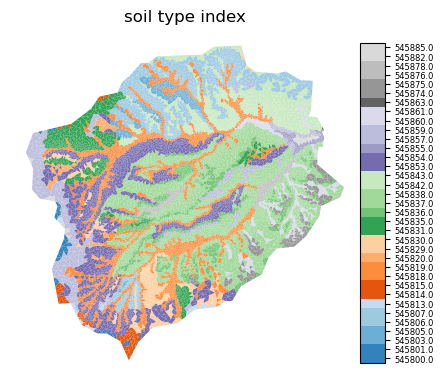

In [24]:
# plot the soil mukey
indices, cmap, norm, ticks, labels = \
        watershed_workflow.colors.generate_indexed_colormap(soil_color, cmap='tab20c')
fig, ax = watershed_workflow.plot.get_ax(crs, figsize=(5,4), window=[0.,0.,0.7,0.9])
cax = fig.add_axes([0.7,0.05,0.05,0.8])

mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                        linewidth=0, color=soil_color, 
                        cmap=cmap, norm=norm
                       )

cbar = watershed_workflow.colors.colorbar_index(ncolors=len(np.unique(soil_color)), 
                                                cmap=cmap, labels=labels, cax=cax)
cbar.ax.tick_params(labelsize=6)

ax.set_title('soil type index')
ax.axis('off')



Index(['mukey', 'residual saturation [-]', 'Rosetta porosity [-]',
       'van Genuchten alpha [Pa^-1]', 'van Genuchten n [-]',
       'Rosetta permeability [m^2]', 'thickness [cm]', 'permeability [m^2]',
       'porosity [-]', 'bulk density [g/cm^3]', 'total sand pct [%]',
       'total silt pct [%]', 'total clay pct [%]', 'source'],
      dtype='object')
min, max =  0.2355549116198203 0.467109593771068


/home/ecoon/code/miniforge3/envs/watershed-workflow-master-20240507/lib/python3.10/site-packages/pyproj/crs/crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


(273712.5998, 279399.40619999997, 3878583.92855, 3884209.4924500003)

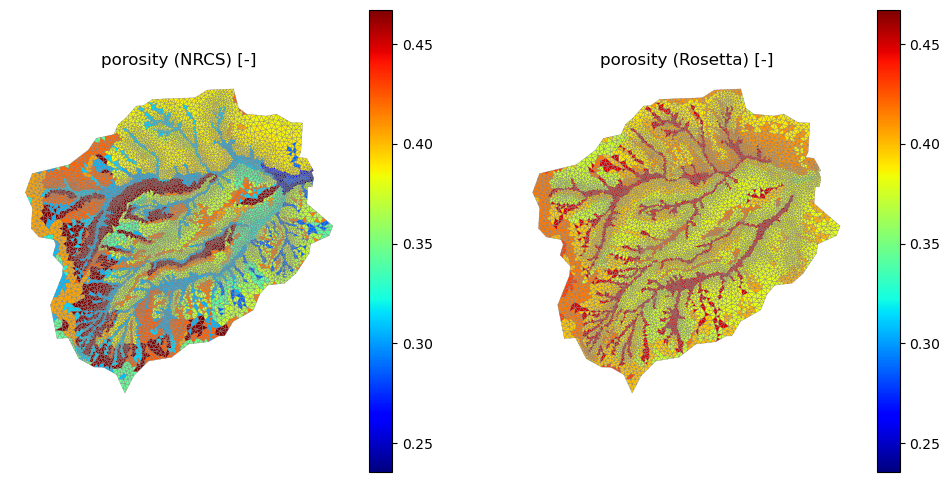

In [25]:
# Note this is not just the soil ID, but also soil properties.  
print(soil_survey_props.keys())
soil_survey_props.set_index('mukey', inplace=True)

# To demonstrate what we mean by this, plot the porosity of the soil column.
porosity_nrcs = np.empty(soil_color.shape, 'd')
porosity_rosetta = np.empty(soil_color.shape, 'd')

for mukey in soil_survey_props.index:
    porosity_nrcs[soil_color == mukey] = soil_survey_props.loc[mukey, 'porosity [-]']
    porosity_rosetta[soil_color == mukey] = soil_survey_props.loc[mukey, 'Rosetta porosity [-]']

pmin = min(np.nanmin(porosity_nrcs), np.nanmin(porosity_rosetta))
pmax = max(np.nanmax(porosity_nrcs), np.nanmax(porosity_rosetta))
print('min, max = ', pmin, pmax)


fig = plt.figure(figsize=(12,6))
ax1 = watershed_workflow.plot.get_ax(crs, fig, nrow=1, ncol=2, index=1)
mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax1, 
                color=porosity_nrcs, edgecolor='gray', cmap='jet', 
                                           vmin=pmin, vmax=pmax)
cbar = fig.colorbar(mp)
ax1.set_title('porosity (NRCS) [-]')
ax1.axis('off')


ax2 = watershed_workflow.plot.get_ax(crs, fig, nrow=1, ncol=2, index=2)
mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax2, 
                                 color=porosity_rosetta, edgecolor='gray', cmap='jet', vmin=pmin, vmax=pmax)
cbar = fig.colorbar(mp)
ax2.set_title('porosity (Rosetta) [-]')
ax2.axis('off')


(273712.5998, 279399.40619999997, 3878583.92855, 3884209.4924500003)

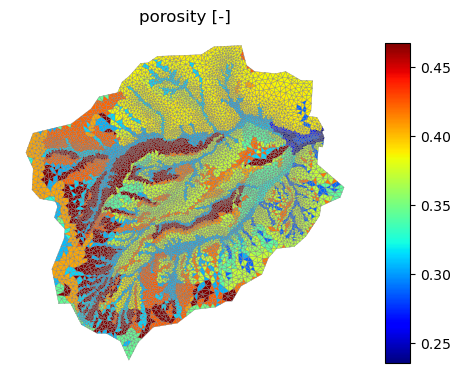

In [26]:
# plot the soil porosity again
fig, ax = watershed_workflow.plot.get_ax(crs, figsize=(5,4), window=[0.,0.,0.7,0.9])
cax = fig.add_axes([0.75,0.05,0.05,0.8])

mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                color=porosity_nrcs, edgecolor='gray', cmap='jet', 
                                           vmin=pmin, vmax=pmax)
cbar = fig.colorbar(mp, cax=cax)

ax.set_title('porosity [-]')
ax.axis('off')

min = -14.488486163789586, max = -11.204929002586569


Text(0.5, 1.0, 'log permeability (Rosetta) [m^2]')

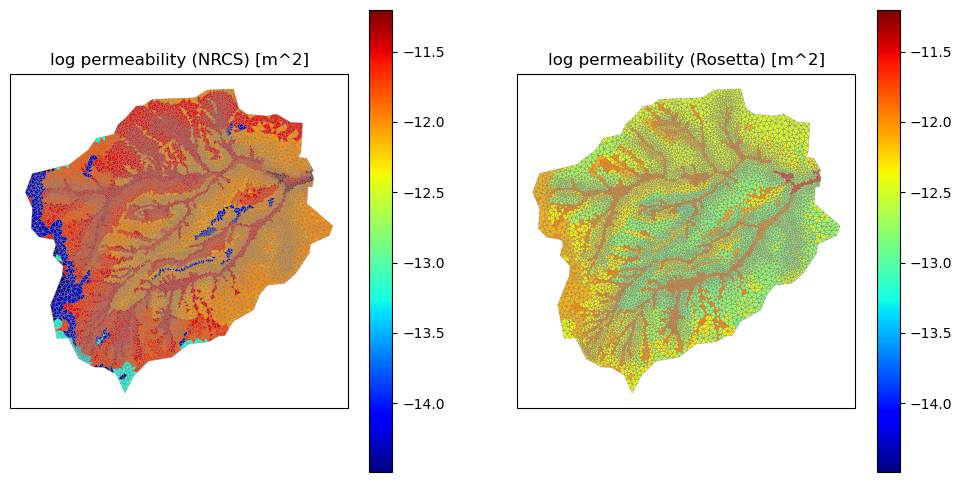

In [27]:
# averaging permeability is a tricky beast.  we average in log space, check that 
# unit conversions make sense
fig = plt.figure(figsize=(12,6))
soil_perm_nrcs = np.empty(soil_color.shape, 'd')
soil_perm_rosetta = np.empty(soil_color.shape, 'd')

for mukey in soil_survey_props.index:
    soil_perm_nrcs[soil_color == mukey] = soil_survey_props.loc[mukey, 'permeability [m^2]']
    soil_perm_rosetta[soil_color == mukey] = soil_survey_props.loc[mukey, 'Rosetta permeability [m^2]']

pmin = min(np.log10(soil_perm_nrcs).min(), np.log10(soil_perm_rosetta).min())
pmax = max(np.log10(soil_perm_nrcs).max(), np.log10(soil_perm_rosetta).max())

  
print(f'min = {pmin}, max = {pmax}')

ax1 = watershed_workflow.plot.get_ax(crs, fig, nrow=1, ncol=2, index=1)
mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax1, 
                                 color=np.log10(soil_perm_nrcs), edgecolor='gray', cmap='jet',
                                vmin=pmin, vmax=pmax)
cbar = fig.colorbar(mp)
ax1.set_title('log permeability (NRCS) [m^2]')

ax2 = watershed_workflow.plot.get_ax(crs, fig, nrow=1, ncol=2, index=2)
mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax2, 
                                 color=np.log10(soil_perm_rosetta), edgecolor='gray', cmap='jet',
                                vmin=pmin, vmax=pmax)
cbar = fig.colorbar(mp)
ax2.set_title('log permeability (Rosetta) [m^2]')




[203. 203. 203. ... 203. 203. 203.]
Median soil thickness [-] =  2.03


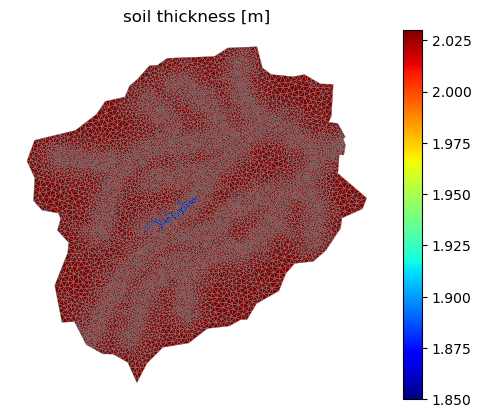

In [28]:
# finally, let's look at the soil thickness, which will define the depth of this layer
soil_thickness = np.zeros(soil_color.shape, 'd')
for mukey in soil_survey_props.index:
    soil_thickness[soil_color == mukey] = soil_survey_props.loc[mukey, 'thickness [cm]']

print(soil_thickness)
soil_thickness = soil_thickness / 100
fig, ax = watershed_workflow.plot.get_ax(crs)
mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=soil_thickness, edgecolor='gray', cmap='jet')
ax.set_title('soil thickness [m]')
cb = fig.colorbar(mp, fraction=0.04, pad=0.04)
ax.axis('off')

print('Median soil thickness [-] = ', np.nanmedian(soil_thickness))

### GLYHMPS geologic layer

In [29]:
# extract the GLYHMPS geologic structure data as shapes and project it onto the mesh
target_bounds = coweeta.exterior().bounds
logging.info('target bounds: {}'.format(target_bounds))

_, geo_survey, geo_survey_props = \
    watershed_workflow.get_shapes(sources['geologic structure'], target_bounds, 
                                  crs, crs, properties=True)

# -- log the bounds targetted and found
logging.info('shape union bounds: {}'.format(
    shapely.ops.cascaded_union(geo_survey).bounds))

# -- determine the ID for each soil unit; this uniquely identifies formation
#    properties
geo_ids = np.array([shp.properties['id'] for shp in geo_survey], np.int32)

# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
geo_color_profile, geo_color_raster = \
            watershed_workflow.color_raster_from_shapes(geo_survey, crs, geo_ids,
                                                        target_bounds, 10, crs, -1)

# -- resample the raster to the triangles
geo_color = watershed_workflow.values_from_raster(m2.centroids, crs, 
                                         geo_color_raster, geo_color_profile)


2024-07-18 10:50:04,272 - root - INFO: target bounds: (273971.0911428096, 3878839.6361173145, 279140.9150949494, 3883953.7853134344)
2024-07-18 10:50:04,274 - root - INFO: 
2024-07-18 10:50:04,274 - root - INFO: Loading shapes
2024-07-18 10:50:04,275 - root - INFO: ------------------------------
2024-07-18 10:50:04,277 - root - INFO: Getting shapes of GLHYMPS on bounds: (273971.0911428096, 3878839.6361173145, 279140.9150949494, 3883953.7853134344)
2024-07-18 10:50:04,299 - root - INFO: ... found 1 shapes
2024-07-18 10:50:04,300 - root - INFO: Converting to shapely
2024-07-18 10:50:04,302 - root - INFO:  ... done
2024-07-18 10:50:04,304 - root - INFO: Converting to requested CRS
2024-07-18 10:50:04,321 - root - INFO:  ... done
2024-07-18 10:50:04,325 - root - INFO: shape union bounds: (159518.2701164111, 3816621.6554112737, 431027.3363569959, 4024643.434646188)
2024-07-18 10:50:04,326 - root - INFO: Coloring shapes onto raster:
2024-07-18 10:50:04,327 - root - INFO:   of shape: (512, 51

/home/ecoon/code/miniforge3/envs/watershed-workflow-master-20240507/lib/python3.10/site-packages/pyproj/crs/crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


kwargs =  {'linewidth': 0, 'cmap': 'tab20c'}
setting face color =  [1793338. 1793338. 1793338. ... 1793338. 1793338. 1793338.]


,id,source,permeability [m^2],logk_stdev [-],porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],residual saturation [-]
0,1793338,GLHYMPS,3.019952e-11,1.61,0.01,0.023953,2.0,0.01


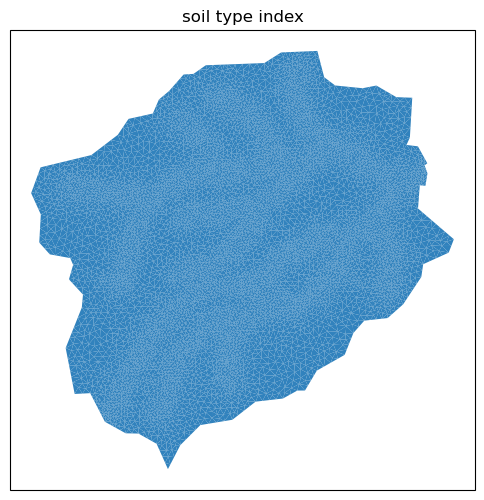

In [30]:
# plot the geologic formation id
fig = plt.figure(figsize=figsize)
ax = watershed_workflow.plot.get_ax(crs, fig)

mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                                 linewidth=0, color=geo_color, cmap='tab20c')
ax.set_title('soil type index')
geo_survey_props



## Depth-to-bedrock

Depth to bedrock is taken from the [SoilGrids](http://globalchange.bnu.edu.cn/research/dtb.jsp) product.  Here we download a US-based, clipped version of this global product, as file sizes are quite large (all products potentially used total over 100GB).

In [31]:
DTB_profile, DTB_raster = watershed_workflow.get_raster_on_shape(sources['depth to bedrock'], 
                                                                 coweeta.exterior(), crs, 
                                                                 nodata=-99999)
                                        #, variable='BDTICM') # note, this argument needed for 
                                        # using the default SoilGrids dataset.

# resample the raster to the triangles
DTB_raster = DTB_raster/100 #convert from cm to m
DTB = watershed_workflow.values_from_raster(m2.centroids, crs, DTB_raster, DTB_profile, algorithm='piecewise bilinear')
DTB = np.where(DTB >= 0, DTB, np.nan)

2024-07-18 10:50:05,848 - root - INFO: 
2024-07-18 10:50:05,848 - root - INFO: Loading Raster
2024-07-18 10:50:05,849 - root - INFO: ------------------------------
2024-07-18 10:50:05,849 - root - INFO: Collecting raster
2024-07-18 10:50:05,853 - root - INFO: bounds in my_crs: (-83.47845037186387, 35.02734099944037, -83.42165773504303, 35.07381933600275)
2024-07-18 10:50:05,854 - root - INFO: ... got raster of shape: (23, 28)
2024-07-18 10:50:05,855 - root - INFO: ... got raster bounds: (-83.47918210999998, 35.074175034, -83.42084878599998, 35.026258375)


/home/ecoon/code/miniforge3/envs/watershed-workflow-master-20240507/lib/python3.10/site-packages/pyproj/crs/crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


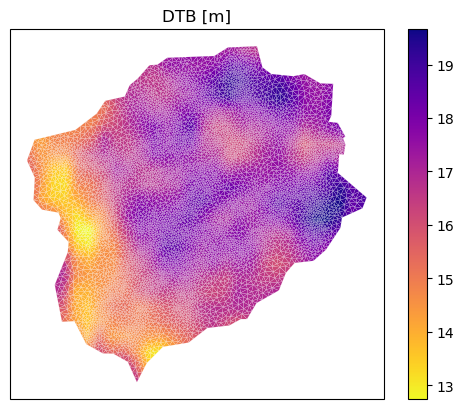

In [32]:
# plot the resulting surface mesh
fig, ax = watershed_workflow.plot.get_ax(crs)

mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=DTB, cmap='plasma_r', edgecolor='white', linewidth=0.1)
cbar = fig.colorbar(mp)
title = ax.set_title('DTB [m]')


## Mesh extrusion

Given the surface mesh and material IDs on both the surface and subsurface, we can extrude the surface mesh in the vertical to make a 3D mesh.

First, all integer IDs in Exodus files must be unique.  This includes Material IDs, side sets, etc.  We create the Material ID map and data frame.  This is used to standardize IDs from multiple data sources.  Traditionally, ATS numbers Material IDs/Side Sets as:

* 0-9 : reserved for boundaries, surface/bottom, etc
* 10-99 : Land Cover side sets, typically NLCD IDs are used
* 100-999 : geologic layer material IDs
* 1000-9999 : soil layer material IDs




In [33]:
soil_survey_props['ats_id'] = range(1000, 1000+len(soil_survey_props))
soil_survey_props.set_index('ats_id', inplace=True)

geo_survey_props['ats_id'] = range(100, 100+len(geo_survey_props))
geo_survey_props.set_index('ats_id', inplace=True)

subsurface_props = pandas.concat([geo_survey_props,soil_survey_props])

In [34]:
# must choose properties for geologic media.  Here we choose one that has a similar porosity
subsurface_props.loc[100, ['residual saturation [-]', 'van Genuchten alpha [Pa^-1]', 'van Genuchten n [-]']] =  \
      subsurface_props.loc[1024, ['residual saturation [-]', 'van Genuchten alpha [Pa^-1]', 'van Genuchten n [-]']] 

# save the properties to disk for use in generating input file
subsurface_props.to_csv(os.path.join('Coweeta', 'output_data', 'coweeta_subsurface_properties.csv'))



Next we extrude the DEM to create a 3D mesh.

The most difficult aspect of extrusion is creating meshes that:
1. aren't huge numbers of cells
2. aren't huge cell thicknesses, especially near the surface
3. follow implied interfaces, e.g. bottom of soil and bottom of geologic layer

This is an iterative process that requires some care and some art.

In [35]:
# Generate a dz structure for the top 2m of soil -- it appears from above that the soil thickness is uniformly 2m
#
# here we try for 10 cells, starting at 5cm at the top and going to 50cm at the bottom of the 2m thick soil
dzs, res = watershed_workflow.mesh.optimize_dzs(0.05, 0.5, 2, 10)
print(dzs)

[0.0500016  0.05030145 0.06625834 0.1110568  0.22600204 0.49640501
 0.49997989 0.49999487]


In [36]:
# this looks like it would work out:
dzs = [0.05, 0.05, 0.05, 0.12, 0.23, 0.5, 0.5, 0.5]
print(sum(dzs))

2.0


In [37]:
# a 2m soil thickness and a maximum of 20m depth to bedrock suggests a
# geologic layer of 18 - 1m cells
dzs = dzs + [1.0,]*18


In [38]:
# layer extrusion
# -- data structures needed for extrusion
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []

# -- add the layers
depth = 0
for dz in dzs:
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    
    # to set the layer type, we check whether it is
    #   * above the soil thickness (it is soil)
    #   * below the depth to bedrock (it is bedrock)
    #   * else it is geologic layer
    # -- set the depth as the cell midpoint
    depth += 0.5 * dz
    
    # -- bedrock (999) or geologic layer (from geo_color)
    br_or_geo = np.where(depth < DTB, geo_color, 999)
    
    # -- are we in the soil horizons?
    mat_id = np.where(np.bitwise_and(soil_color > 0, depth < soil_thickness),
                      soil_color, br_or_geo)

    depth += 0.5 * dz
    layer_mat_ids.append(mat_id)
    
# print the summary
watershed_workflow.mesh.Mesh3D.summarize_extrusion(layer_types, layer_data, 
                                            layer_ncells, layer_mat_ids)

2024-07-18 10:50:06,228 - root - INFO: Cell summary:
2024-07-18 10:50:06,228 - root - INFO: ------------------------------------------------------------
2024-07-18 10:50:06,228 - root - INFO: l_id	| c_id	|mat_id	| dz		| z_top
2024-07-18 10:50:06,228 - root - INFO: ------------------------------------------------------------
2024-07-18 10:50:06,228 - root - INFO:  00 	| 00 	| 545882 	|   0.050000 	|   0.000000
2024-07-18 10:50:06,229 - root - INFO:  01 	| 01 	| 545882 	|   0.050000 	|   0.050000
2024-07-18 10:50:06,229 - root - INFO:  02 	| 02 	| 545882 	|   0.050000 	|   0.100000
2024-07-18 10:50:06,229 - root - INFO:  03 	| 03 	| 545882 	|   0.120000 	|   0.150000
2024-07-18 10:50:06,230 - root - INFO:  04 	| 04 	| 545882 	|   0.230000 	|   0.270000
2024-07-18 10:50:06,230 - root - INFO:  05 	| 05 	| 545882 	|   0.500000 	|   0.500000
2024-07-18 10:50:06,230 - root - INFO:  06 	| 06 	| 545882 	|   0.500000 	|   1.000000
2024-07-18 10:50:06,230 - root - INFO:  07 	| 07 	| 545882 	|   0

In [39]:
# extrude
m3 = watershed_workflow.mesh.Mesh3D.extruded_Mesh2D(m2, layer_types, layer_data, 
                                             layer_ncells, layer_mat_ids)

In [40]:
# add back on land cover side sets
surf_ss = m3.side_sets[1]

for index, name in zip(nlcd_indices, nlcd_labels):
    where = np.where(lc == index)[0]
    ss = watershed_workflow.mesh.SideSet(name, int(index), 
                            [surf_ss.cell_list[w] for w in where],
                            [surf_ss.side_list[w] for w in where])        
    m3.side_sets.append(ss)

In [41]:
# save to disk
filename = os.path.join('Coweeta', 'output_data', 'coweeta_basin')

if watershed_workflow.mesh.exodus is not None:
    try:
        os.remove(filename+'.exo')
    except FileNotFoundError:
        pass
    m3.write_exodus(filename+'.exo')

else:
    try:
        os.remove(filename+'.vtk')
    except FileNotFoundError:
        pass
    m3.write_vtk(filename+'.vtk')


You are using exodus.py v 1.20.10 (seacas-py3), a python wrapper of some of the exodus library.

Copyright (c) 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021 National Technology &
Engineering Solutions of Sandia, LLC (NTESS).  Under the terms of
Contract DE-NA0003525 with NTESS, the U.S. Government retains certain
rights in this software.

Opening exodus file: Coweeta/output_data/coweeta_basin.exo


2024-07-18 10:50:11,058 - root - INFO: adding side set: 1
2024-07-18 10:50:11,128 - root - INFO: adding side set: 2
2024-07-18 10:50:11,155 - root - INFO: adding side set: 3
2024-07-18 10:50:11,170 - root - INFO: adding side set: 21
2024-07-18 10:50:11,184 - root - INFO: adding side set: 22
2024-07-18 10:50:11,199 - root - INFO: adding side set: 23
2024-07-18 10:50:11,212 - root - INFO: adding side set: 41
2024-07-18 10:50:11,228 - root - INFO: adding side set: 42
2024-07-18 10:50:11,242 - root - INFO: adding side set: 43
2024-07-18 10:50:11,259 - root - INFO: adding side set: 52
2024-07-18 10:50:11,272 - root - INFO: adding side set: 81


Closing exodus file: Coweeta/output_data/coweeta_basin.exo
